In [38]:
#importing libraries 
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import numpy as np
import skbio
import skbio.diversity
import skbio.stats.composition
import scipy
import pylab as pl
import statsmodels.api as sm
from functools import reduce
from scipy import stats

%matplotlib inline

import arivale_data_interface as adi
# apply settings so the lib knows where the data is
adi.apply_isb_config()

#list the local snapshots
local_snapshots = adi.list_local_snapshots()
print(len(local_snapshots))
local_snapshots[0]

# ignore deprecation warnings
import warnings
warnings.filterwarnings('ignore')

98


In [39]:
#read in ASV table
asvs = pd.read_csv("/proj/arivale/microbiome/16S_processed/asvs.csv")

#read in samples metadata
samples = pd.read_csv("/proj/arivale/microbiome/16S_processed/metadata.csv")

#read in taxonomy data
tax = pd.read_csv("/proj/arivale/microbiome/16S_processed/taxonomy.csv")

#load in chemistries snapshot 
chemistries = adi.get_snapshot('chemistries')

#load in lifestyle_assessments snapshot  
lifestyle_assessment = adi.get_snapshot('assessments_raw')

#load in medications_assessments snapshot 
medications = adi.get_snapshot('assessments_medications')
#only include patients who have not taken antibiotics in the last three months 
no_antibiotics = medications[medications['meds_antibiotics_last_3_months'].isin(['No'])]

#import Shannon diversity
shannon_trimmed = adi.get_snapshot('microbiome_trimmed_diversity')
shannon = adi.get_snapshot('microbiome_diversity')

In [40]:
# view head size of dataframe containing all samples
all_samples = samples.copy(deep=True)
all_samples_ids = all_samples['id'].values
all_samples.head()
all_samples.shape

(5232, 24)

<AxesSubplot:xlabel='age', ylabel='Density'>

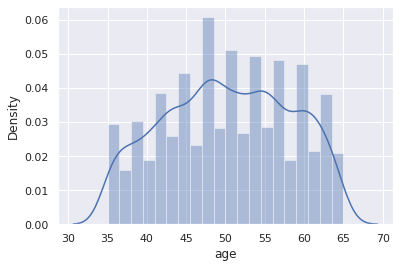

In [41]:
#merge samples with antibiotics data
samples_noab = pd.merge(all_samples,no_antibiotics[['public_client_id',
                                                           'meds_antibiotics_last_3_months',]],on='public_client_id')

#filter out ages in the outside range
samples_over35 = samples_noab[samples_noab['age'] >=35]
age_filtered_samples = samples_over35[samples_over35['age'] <= 65]
age_filtered_samples.shape
sns.distplot(age_filtered_samples['age'])

<AxesSubplot:xlabel='days_since_first_draw', ylabel='Density'>

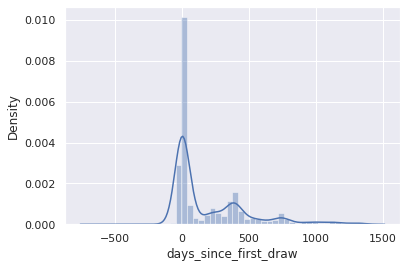

In [42]:
# distribution of days since first blood draw
sns.distplot(age_filtered_samples['days_since_first_draw'])

In [43]:
#filter for checkpoint1 samples (30 days or less)
baseline_samples = age_filtered_samples.copy(deep=True)
baseline_samples['days_since_first_draw_abs'] = baseline_samples['days_since_first_draw'].abs()
baseline_samples = baseline_samples[baseline_samples['days_since_first_draw'].abs() <= 30]
ckpt1_samples = baseline_samples.sort_values('days_since_first_draw_abs').groupby('public_client_id').first()

#filter for baseline chemistries
ckpt1_chemistries = chemistries[chemistries['days_since_first_draw'].abs() <= 30]

#merge with HbA1C data
ckpt1_metadata = pd.merge(ckpt1_samples,ckpt1_chemistries[['public_client_id','GLYCOHEMOGLOBIN A1C']],on='public_client_id')


#only include HbA1C levels above the healthy HbA1C threshold
ckpt1_metadata = ckpt1_metadata[ckpt1_metadata['GLYCOHEMOGLOBIN A1C']>=5.0]
ckpt1_metadata.shape

(1897, 27)

In [44]:
#rename 'days since first draw' column to 'time point'
ckpt1_metadata = ckpt1_metadata.rename(columns={'days_since_first_draw': 'time point'})

#replace all values in the time point column with 0
ckpt1_metadata['time point'] = np.where(ckpt1_metadata['time point'] <= 30, 0, 
                                                ckpt1_metadata['time point'])

In [45]:
#filter for checkpoint2 samples (~6months)
samples2 = age_filtered_samples.copy(deep=True)
samples2['days_since_first_draw_abs'] = samples2['days_since_first_draw'].abs()
samples2 = samples2[samples2['days_since_first_draw'].abs() <= 400]
ckpt2_samples = samples2[samples2['days_since_first_draw'].abs() >180]
ckpt2_samples = ckpt2_samples.sort_values('days_since_first_draw_abs').groupby('public_client_id').first()
#sixmonth_samples_ids = sixmonth_samples['id'].values


ckpt2_samples.shape

(607, 25)

In [46]:
#only indlude six month blood draw data for chemistries
baseline_chemistries2 = chemistries.copy(deep=True)
baseline_chemistries2 = baseline_chemistries2[baseline_chemistries2['days_since_first_draw'].abs() <= 400]
ckpt2_chemistries = baseline_chemistries2[baseline_chemistries2['days_since_first_draw'].abs() >180]
ckpt2_chemistries.shape

#merge with insulin data
ckpt2_metadata = pd.merge(ckpt2_samples,ckpt2_chemistries[['public_client_id','GLYCOHEMOGLOBIN A1C']],on='public_client_id')

ckpt2_metadata.shape



(769, 27)

In [47]:
ckpt2_metadata = ckpt2_metadata.rename(columns={'days_since_first_draw': 'time point'})
ckpt2_metadata['time point'] = np.where(ckpt2_metadata['time point'] <= 400, 6, 
                                                ckpt2_metadata['time point'])

In [48]:
#convert bl_metadata from longform to wide form
ckpt1_long = pd.melt(ckpt1_metadata,id_vars=['public_client_id','time point'],value_vars=['GLYCOHEMOGLOBIN A1C'])
ckpt1_long =ckpt1_long.drop(['variable'],axis=1)

In [49]:
#convert sixmonth_metadata from longform to wide form
ckpt2_long = pd.melt(ckpt2_metadata,id_vars=['public_client_id','time point'],value_vars=['GLYCOHEMOGLOBIN A1C'])
ckpt2_long =ckpt2_long.drop(['variable'],axis=1)

In [50]:
#combine baseline and sixmonth metadata
ckptALL_long = [ckpt1_long,ckpt2_long]
ckptALL_longdata = pd.concat(ckptALL_long)
ckptALL_longdata = ckptALL_longdata.rename(columns={'value':'HbA1C'})

<AxesSubplot:xlabel='time point', ylabel='HbA1C'>

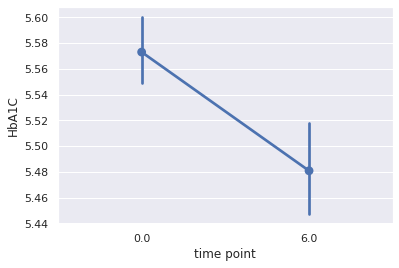

In [51]:
# change in HbA1C levels between two checkpoints
sns.pointplot(x='time point',y='HbA1C',data=ckptALL_longdata)

In [52]:
#rename 'HBA1C' column to 'BL_HBA1C' in bl_metadata2 dataframe
ckpt1_metadata2 = ckpt1_metadata.rename({'time point':'BL_time_point','GLYCOHEMOGLOBIN A1C':'BL_HbA1C'},axis=1)
ckpt1_metadata2.shape

(1897, 27)

In [53]:
# rename 'HBA1C' column to '2nd_HBA1C' in sixmonth_metadata2 dataframe
ckpt2_metadata2 = ckpt2_metadata.rename({'time point':'2nd_time_point','GLYCOHEMOGLOBIN A1C':'2nd_HbA1C'},axis=1)
ckpt2_metadata2.shape

(769, 27)

In [54]:
#create dataframe of baseline and 6 month insulin data
ckptALL_metadata = pd.merge(ckpt1_metadata2,ckpt2_metadata2[['public_client_id','2nd_time_point','2nd_HbA1C']],
                          on='public_client_id')
#bl6mo_metadata = bl6mo_metadata['BL_INSULIN'].dropna()
ckptALL_metadata['public_client_id'].nunique()
ckptALL_metadata.head()
unique_ckptALL_metadata = ckptALL_metadata.drop_duplicates('public_client_id')
unique_ckptALL_metadata['public_client_id'].nunique()
unique_ckptALL_metadata.shape

(450, 29)

In [55]:
################################
# DELTA CALCULATION
# create empty list for change in HbA1C
Delta = []

# create for loop that 
for row1 in unique_ckptALL_metadata['BL_HbA1C']:
    for row2 in unique_ckptALL_metadata['2nd_HbA1C']:
        Delta.append(row1 - row2)

# absolute value of delta        
Delta_abs = [abs(ele) for ele in Delta]

# add delta column to BL and 6 month metadata
unique_ckptALL_metadata['Delta'] = Delta_abs[0:450]
#len(Delta_abs)
unique_ckptALL_metadata.head()

,public_client_id,genome_id,genome_vendor,multiple_genome_ids,client_id,user_id,sex,race,has_research_consent,enterprise,...,BL_time_point,month,weekday,id,meds_antibiotics_last_3_months,days_since_first_draw_abs,BL_HbA1C,2nd_time_point,2nd_HbA1C,Delta
0,01004596,DS-267294,NEXTCODE,NaN,162347.0,81043448-c215-489d-ac48-4e11113f82a2,F,white,True,ce0cf55cf4a60dd0,...,0.0,Feb,Mon,22001612561407|GFM-1079-001,No,3.0,5.5,6.0,5.5,0.0
2,01005100,DS-293608,WUXI_SNP,NaN,268339.0,ec9e8086-1f28-44e8-81f8-f4732d6bda1c,F,white,True,aac0298a21469db8,...,0.0,Apr,Mon,22001803512697|GFM-1079-024,No,10.0,5.4,6.0,5.2,0.3
3,01005890,DS-243921,NEXTCODE,NaN,135726.0,659c5b87-e32f-4b15-98fc-81e995e347bd,M,asian,True,f89affb34da2473b,...,0.0,Jul,Fri,AV15-3836|AKE025,No,6.0,5.6,6.0,5.8,0.3
4,01006695,DS-291353,WUXI_SNP,NaN,253022.0,c17dcc57-022d-483e-b3be-1386820f5e19,M,white,True,f1c39fea488575ec,...,0.0,Mar,Mon,22001701510224|GFM-1079-022,No,3.0,5.4,6.0,5.5,0.0
5,01006974,A941AR682-005,NEXTCODE,NaN,327.0,0aba2f91-f7fc-4731-b425-72f3c5d1926a,M,white,True,d4cd0dabcf4caa22,...,0.0,Jul,Tue,AV15-1038|AKE007,No,0.0,5.1,6.0,5.4,0.1


In [56]:
# intermediate dataframe before normally distribution of delta values
# drop zero and infinity values from delta column 
int_dataframe = unique_ckptALL_metadata.copy(deep=True)
int_dataframe.head()

,public_client_id,genome_id,genome_vendor,multiple_genome_ids,client_id,user_id,sex,race,has_research_consent,enterprise,...,BL_time_point,month,weekday,id,meds_antibiotics_last_3_months,days_since_first_draw_abs,BL_HbA1C,2nd_time_point,2nd_HbA1C,Delta
0,01004596,DS-267294,NEXTCODE,NaN,162347.0,81043448-c215-489d-ac48-4e11113f82a2,F,white,True,ce0cf55cf4a60dd0,...,0.0,Feb,Mon,22001612561407|GFM-1079-001,No,3.0,5.5,6.0,5.5,0.0
2,01005100,DS-293608,WUXI_SNP,NaN,268339.0,ec9e8086-1f28-44e8-81f8-f4732d6bda1c,F,white,True,aac0298a21469db8,...,0.0,Apr,Mon,22001803512697|GFM-1079-024,No,10.0,5.4,6.0,5.2,0.3
3,01005890,DS-243921,NEXTCODE,NaN,135726.0,659c5b87-e32f-4b15-98fc-81e995e347bd,M,asian,True,f89affb34da2473b,...,0.0,Jul,Fri,AV15-3836|AKE025,No,6.0,5.6,6.0,5.8,0.3
4,01006695,DS-291353,WUXI_SNP,NaN,253022.0,c17dcc57-022d-483e-b3be-1386820f5e19,M,white,True,f1c39fea488575ec,...,0.0,Mar,Mon,22001701510224|GFM-1079-022,No,3.0,5.4,6.0,5.5,0.0
5,01006974,A941AR682-005,NEXTCODE,NaN,327.0,0aba2f91-f7fc-4731-b425-72f3c5d1926a,M,white,True,d4cd0dabcf4caa22,...,0.0,Jul,Tue,AV15-1038|AKE007,No,0.0,5.1,6.0,5.4,0.1


In [57]:
# replace all 0 values with NaN (because you can't take the log of 0)
int_dataframe['Delta'].replace(0,np.nan,inplace=True)

In [58]:
# drop all NaN values
no_na = int_dataframe.dropna(subset=['Delta'])
no_na.shape

(380, 30)

In [59]:
#normalized delta values by taking the log value
normal_delta = np.log10(no_na['Delta'])

In [60]:
len(normal_delta)

380

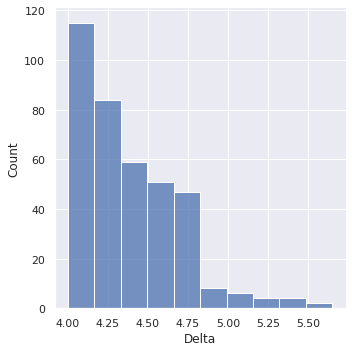

In [65]:
#add +1 to all values
normal_delta = normal_delta+1
sns.displot(normal_delta)

In [149]:
no_na.shape

(380, 30)

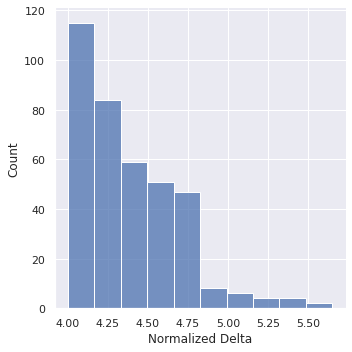

In [66]:
# add normalized delta to table
no_na['Normalized Delta'] = normal_delta[0:380]
sns.displot(no_na['Normalized Delta'])

In [151]:
normalized_data = no_na.copy()
normalized_data.describe()

,client_id,age,days_in_program,days_since_first_call,BL_time_point,days_since_first_draw_abs,BL_HbA1C,2nd_time_point,2nd_HbA1C,Delta,Normalized Delta
count,380.000000,380.000000,380.000000,379.000000,380.0,380.000000,380.000000,380.0,380.000000,380.000000,3.800000e+02
mean,122538.139474,51.271053,24.342105,0.065963,0.0,5.421053,5.569211,6.0,5.539474,0.342105,3.837259e-01
std,95902.335383,7.972426,25.163818,21.708467,0.0,6.838628,0.579532,0.0,0.544456,0.425029,3.295321e-01
min,237.000000,35.000000,1.000000,-182.000000,0.0,0.000000,5.000000,6.0,4.200000,0.100000,-1.554312e-15
25%,667.750000,46.000000,9.000000,-7.000000,0.0,0.000000,5.300000,6.0,5.200000,0.100000,-1.554312e-15
50%,164926.500000,52.000000,16.000000,0.000000,0.0,3.000000,5.500000,6.0,5.400000,0.200000,3.010300e-01
75%,185891.500000,57.000000,29.250000,6.000000,0.0,9.000000,5.700000,6.0,5.700000,0.400000,6.020600e-01
max,275907.000000,65.000000,162.000000,148.000000,0.0,29.000000,10.500000,6.0,10.000000,4.500000,1.653213e+00


<AxesSubplot:xlabel='BL_HbA1C', ylabel='Delta'>

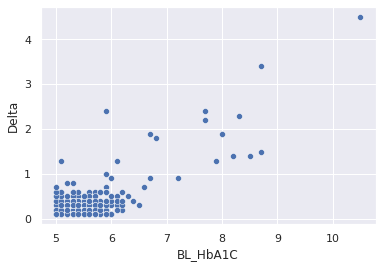

In [152]:
sns.scatterplot(data=normalized_data, x='BL_HbA1C',y='Delta')

<AxesSubplot:xlabel='BL_HbA1C', ylabel='Normalized Delta'>

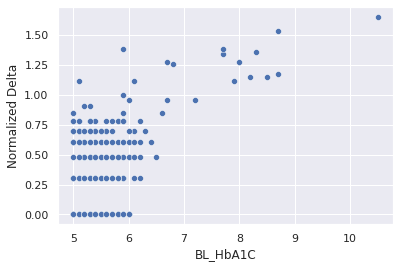

In [153]:
sns.scatterplot(data=normalized_data, x='BL_HbA1C',y='Normalized Delta')

In [154]:
##################################
# LINEAR REGRESSION USING STATSMODELS - GETTING RESIDUALS FOR CONT MODELS

In [155]:
normalized_data = normalized_data.rename(columns={'Normalized Delta':'Delta2'})

In [156]:
import statsmodels.api as sm

In [157]:
from statsmodels.formula.api import ols

In [158]:
# linear regression to fit baseline HbA1C levels to delta values
delta_model = ols('Delta ~ BL_HbA1C', data=normalized_data).fit()

In [159]:
# get residuals
continuous_residuals = delta_model.resid

In [160]:
# print summary
print(delta_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Delta   R-squared:                       0.534
Model:                            OLS   Adj. R-squared:                  0.533
Method:                 Least Squares   F-statistic:                     433.8
Date:                Tue, 03 Nov 2020   Prob (F-statistic):           1.02e-64
Time:                        09:29:30   Log-Likelihood:                -68.340
No. Observations:                 380   AIC:                             140.7
Df Residuals:                     378   BIC:                             148.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.6437      0.144    -18.343      0.0

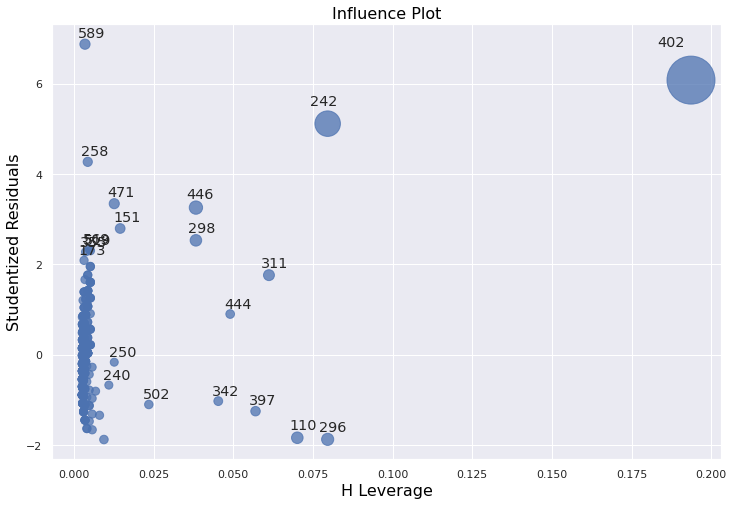

In [161]:
# influence plot
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.influence_plot(delta_model, ax=ax, criterion='cooks')

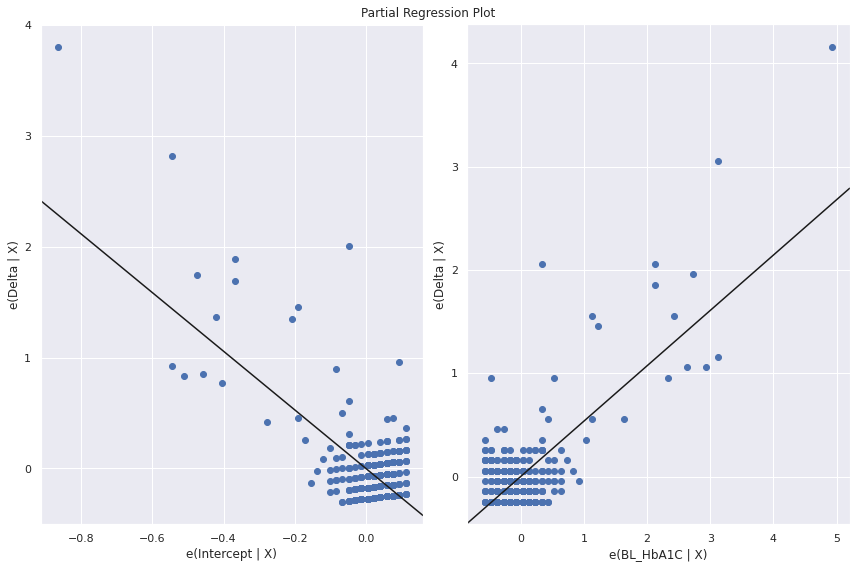

In [162]:
# partial regression plot
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(delta_model, fig=fig)

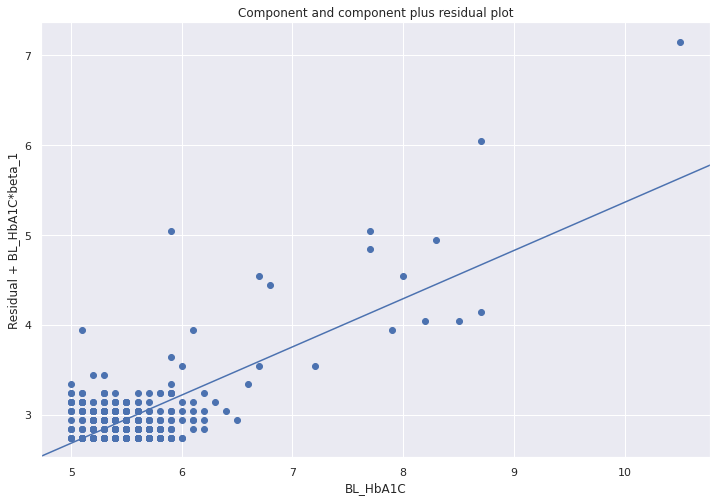

In [163]:
# componenet plus residual plot
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.plot_ccpr(delta_model, 'BL_HbA1C',ax=ax)

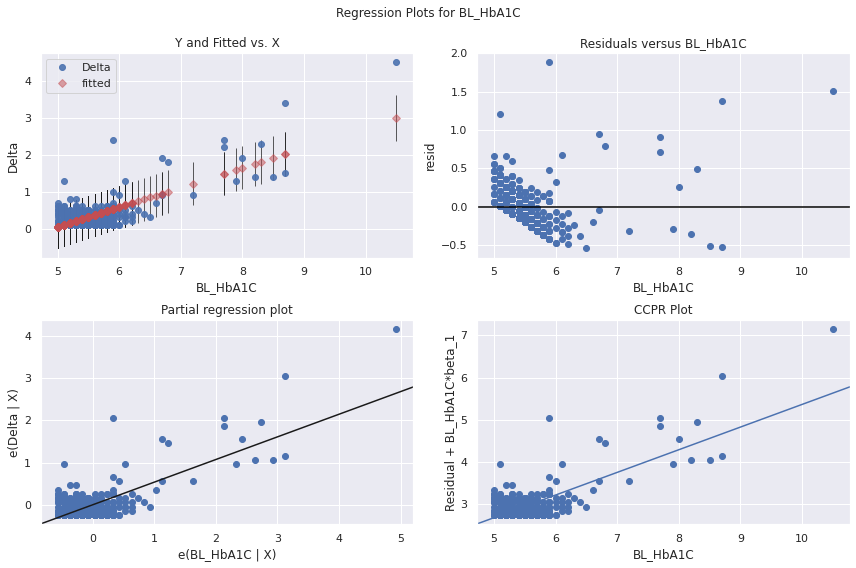

In [164]:
# more regression plots
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(delta_model, 'BL_HbA1C',fig=fig)

In [165]:
# influence
influence = delta_model.get_influence()

In [166]:
# leverage
leverage = influence.hat_matrix_diag

In [167]:
# cooks distance
cooks_d = influence.cooks_distance

In [168]:
# standardized residuals
standardized_residuals = influence.resid_studentized_internal

<AxesSubplot:xlabel='ContResiduals', ylabel='Density'>

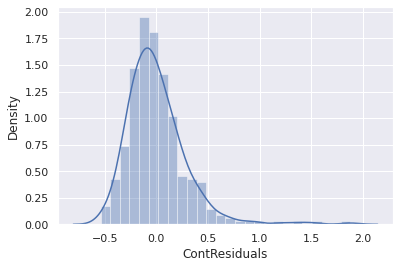

In [169]:
#add residuals to table
normalized_data['ContResiduals'] = continuous_residuals
sns.distplot(normalized_data['ContResiduals'])

<AxesSubplot:xlabel='Residuals', ylabel='Density'>

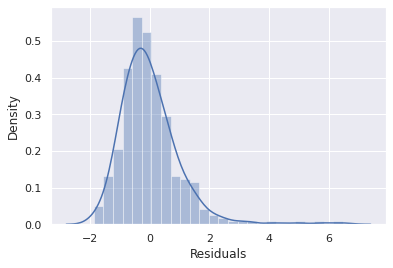

In [170]:
# add standardized residuals to data
normalized_data['Residuals'] = standardized_residuals
sns.distplot(normalized_data['Residuals'])

In [171]:
normalized_data.head()

,public_client_id,genome_id,genome_vendor,multiple_genome_ids,client_id,user_id,sex,race,has_research_consent,enterprise,...,id,meds_antibiotics_last_3_months,days_since_first_draw_abs,BL_HbA1C,2nd_time_point,2nd_HbA1C,Delta,Delta2,ContResiduals,Residuals
2,01005100,DS-293608,WUXI_SNP,NaN,268339.0,ec9e8086-1f28-44e8-81f8-f4732d6bda1c,F,white,True,aac0298a21469db8,...,22001803512697|GFM-1079-024,No,10.0,5.4,6.0,5.2,0.3,4.771213e-01,0.048612,0.167630
3,01005890,DS-243921,NEXTCODE,NaN,135726.0,659c5b87-e32f-4b15-98fc-81e995e347bd,M,asian,True,f89affb34da2473b,...,AV15-3836|AKE025,No,6.0,5.6,6.0,5.8,0.3,4.771213e-01,-0.058612,-0.202091
5,01006974,A941AR682-005,NEXTCODE,NaN,327.0,0aba2f91-f7fc-4731-b425-72f3c5d1926a,M,white,True,d4cd0dabcf4caa22,...,AV15-1038|AKE007,No,0.0,5.1,6.0,5.4,0.1,-1.554312e-15,0.009448,0.032604
6,01008097,DS-269522,NEXTCODE,NaN,164967.0,143086a9-813c-412b-b5d9-18c41181b143,M,ashkenazi jewish,True,ce0cf55cf4a60dd0,...,22001612561622|GFM-1079-003,No,1.0,5.8,6.0,5.7,0.2,3.010300e-01,-0.265836,-0.916777
7,01011802,A042AU490-007,NEXTCODE,NaN,736.0,a0839f01-3fcb-4955-8739-96b8dc55cb22,F,asian,True,d4cd0dabcf4caa22,...,AV15-1478|AKE009,No,0.0,5.0,6.0,5.6,0.1,-1.554312e-15,0.063060,0.217705


[]

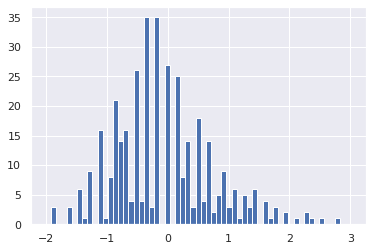

In [172]:
numbins = np.linspace(-2, 3, 60)
plt.hist(normalized_data['Residuals'], bins=numbins)
plt.plot()

### This is where I'll begin the Spearman correlations for the normalized data against "all" of the other types of 'omics data' normalized dataset matrix is called normalized_data. I'll be using the Residuals as my Normal Delta, because they are the remainder of the Delta after the Baseline had been removed

In [173]:
deltas_alone = normalized_data.drop(['genome_id', 'genome_vendor', 'multiple_genome_ids', 'client_id', 
                                     'user_id', 'sex', 'race', 'has_research_consent', 'enterprise', 
                                     'coach', 'region', 'country', 'current_program', 'latest_program', 
                                     'is_helix', 'age', 'vendor_observation_id', 'days_in_program', 'days_since_first_call', 
                                     'BL_time_point', 'month', 'weekday', 'id', 'meds_antibiotics_last_3_months', 
                                     'days_since_first_draw_abs', 'BL_HbA1C', '2nd_time_point', '2nd_HbA1C', 'Delta', 
                                     'Delta2', 'ContResiduals'], axis=1)

deltas_alone = deltas_alone.rename(columns={'Residuals' : 'Normal Delta'})
normalized_data_metrics = list(deltas_alone)
print(normalized_data_metrics)

['public_client_id', 'Normal Delta']


In [174]:
deltas_alone

,public_client_id,Normal Delta
2,01005100,0.167630
3,01005890,-0.202091
5,01006974,0.032604
6,01008097,-0.916777
7,01011802,0.217705
...,...,...
584,HX466574,-0.337221
585,HX501901,-0.706840
587,HX639632,-0.891680
588,HX937051,-0.522034


In [175]:
# weight = adi.get_snapshot('weight')
# weight_rmdups = weight.drop_duplicates(subset = ['public_client_id'], keep='first')

# # merging normalized data with weight datasets, dropping unneccessary columns
# deltas_weights = pd.merge(normalized_data, weight_rmdups, on=['public_client_id'])
# deltas_weights_compact = deltas_weights.drop(['2nd_time_point','BL_HbA1C','Residuals','BL_time_point',
#                                               'month_x','month_y','weekday_y','days_since_first_draw',
#                                               'days_since_first_call_y','days_in_program_y','observation_id',
#                                               '2nd_HbA1C','client_id_y','ContResiduals','vendor','season',
#                                               'waist_circumference','days_since_first_draw_abs','meds_antibiotics_last_3_months',
#                                               'weekday_x','days_since_first_call_x','days_in_program_x','vendor_observation_id',
#                                               'current_program','latest_program','is_helix','client_id_x','coach','region','country',
#                                               'genome_id','genome_vendor','multiple_genome_ids','user_id','sex','race','has_research_consent',
#                                               'enterprise','id'], axis=1)
# #removing rows that contain NaN for any of the values
# deltas_weights_fixed = deltas_weights_compact.dropna()
# deltas_weights_fixed.shape

In [176]:
microbial_diversity_raw = adi.get_snapshot('microbiome_diversity')
microbial_diversity_raw.shape

(5237, 37)

In [177]:
microbial_diversity_rmdups = microbial_diversity_raw.drop_duplicates(subset = ['public_client_id'], keep='first')
deltas_microbial_diversity = pd.merge(normalized_data, microbial_diversity_rmdups, on=['public_client_id'])
deltas_microbial_diversity_compact = deltas_microbial_diversity.drop(['vendor_dashboard','vendor_research','genome_id','genome_vendor','multiple_genome_ids','client_id_x',
                                                                     'days_since_first_draw','user_id','race','enterprise','coach','region','current_program','country','has_research_consent',
                                                                     'latest_program','is_helix','vendor_observation_id_x','days_in_program_x','days_since_first_call_x','BL_time_point','month_x','weekday_x','id',
                                                                     'meds_antibiotics_last_3_months','days_since_first_draw_abs','2nd_time_point','BL_HbA1C','Residuals','Delta2','2nd_HbA1C','client_id_y','ContResiduals',
                                                                     'vendor_observation_id_y','days_in_program_y','days_since_first_call_y','month_y','weekday_y','season'], axis=1)
deltas_microbial_diversity_compact.shape
# pd.set_option('display.max_rows', None)
# print(deltas_microbial_diversity_compact)
microbial_diversity_metrics = list(deltas_microbial_diversity_compact)
print(microbial_diversity_metrics)

['public_client_id', 'sex', 'age', 'Delta', 'MICROBIOME_DIVERSITY_SCORE', 'diversity_PD_whole_tree', 'diversity_chao1', 'diversity_observed_otus', 'diversity_shannon', 'diversity_simpson', 'PD_whole_tree_100000', 'PD_whole_tree_20000', 'PD_whole_tree_30000', 'PD_whole_tree_50000', 'chao1_100000', 'chao1_20000', 'chao1_30000', 'chao1_50000', 'observed_otus_100000', 'observed_otus_20000', 'observed_otus_30000', 'observed_otus_50000', 'shannon_100000', 'shannon_20000', 'shannon_30000', 'shannon_50000', 'simpson_100000', 'simpson_20000', 'simpson_30000', 'simpson_50000']


In [178]:
files = adi.list_snapshot_contents()
print(files)

                              basename  \
0              proteomics_metadata.tsv   
1             microbiome_dashboard.tsv   
2   assessments_exercise_readiness.tsv   
3   assessments_health_history_old.tsv   
4                   analyte_ranges.tsv   
..                                 ...   
67              assessments_stress.tsv   
68                assessments_misc.tsv   
69             assessments_journey.tsv   
70           assessments_education.tsv   
71   proteomics_corrected_external.tsv   

                                              dirname      size  isdir   mode  \
0   /proj/arivale/snapshots/arivale_snapshot_ISB_2...    248162  False  33184   
1   /proj/arivale/snapshots/arivale_snapshot_ISB_2...   1389505  False  33184   
2   /proj/arivale/snapshots/arivale_snapshot_ISB_2...    552055  False  33184   
3   /proj/arivale/snapshots/arivale_snapshot_ISB_2...  30775811  False  33184   
4   /proj/arivale/snapshots/arivale_snapshot_ISB_2...    612873  False  33184   
..       

In [179]:
# deltas_alone = deltas_weights_compact.drop(['age','WEIGHT_CALC','HEIGHT_CALC','BMI_CALC', 'Delta'], axis=1)
# # deltas_alone = deltas_alone.rename(columns={'Delta2':'Normal Delta'})
# # numbins = np.linspace(-0.2, 1.5, 40)
# plt.hist(deltas_alone['Delta2'], bins = numbins)
# plt.plot()
# deltas_alone

In [180]:
deltas_norm = deltas_alone.drop(['public_client_id'], axis=1)
stats.normaltest(deltas_norm, axis=0)

NormaltestResult(statistic=array([191.76345062]), pvalue=array([2.28610294e-42]))

In [181]:
# proteomics analysis begins here

from functools import reduce

# grabbing all of the proteomics files and removing duplicate instances of public_client_id, keeping first instance
# excluding proteomics_corrected_external.tsv

# proteomics_raw = adi.get_snapshot('proteomics_raw')
# proteomics_raw_rmdups = proteomics_raw.drop_duplicates(subset = ['public_client_id'], keep='first')

# proteomics_corrected = adi.get_snapshot('proteomics_corrected')
# proteomics_corrected_rmdups = proteomics_corrected.drop_duplicates(subset = ['public_client_id'], keep='first')

# proteomics_corrected_uncollapsed = adi.get_snapshot('proteomics_corrected_uncollapsed')
# proteomics_corrected_uncollapsed_rmdups = proteomics_corrected_uncollapsed.drop_duplicates(subset = ['public_client_id'], keep='first')

# # storing all dataframes in a list to iterate through so I can merge them all
# deltas_proteomics_dataframes = [deltas_alone, proteomics_raw_rmdups, proteomics_corrected_rmdups, proteomics_corrected_uncollapsed_rmdups]

# # merging all proteomics data files on deltas_alone on public_client_id
# deltas_proteomics = reduce(lambda left, right: pd.merge(left, right, on='public_client_id'), deltas_proteomics_dataframes)

# deltas_proteomics.shape

In [182]:
# perfomring correlation on all proteomics against the deltas
# deltas_proteomics_results = deltas_proteomics.corr(method='spearman')
# deltas_proteomics_results

In [183]:
# microbiome analysis begins here

from functools import reduce

# # grabbing all of the microbiome files and removing duplicate instances of public_client_id, keeping first instance
# # excluding microbiome_analyte_details.tsv, microbiome_otus.tsv, and all trimmed files

# microbiome_dashboard = adi.get_snapshot('microbiome_dashboard')
# microbiome_dashboard_rmdups = microbiome_dashboard.drop_duplicates(subset = ['public_client_id'], keep='first')

# microbiome_diversity = adi.get_snapshot('microbiome_diversity')
# microbiome_diversity_rmdups = microbiome_diversity.drop_duplicates(subset = ['public_client_id'], keep='first')

# microbiome_genera = adi.get_snapshot('microbiome_genera')
# microbiome_genera_rmdups = microbiome_genera.drop_duplicates(subset = ['public_client_id'], keep='first')

# microbiome_kos = adi.get_snapshot('microbiome_kos')
# microbiome_kos_rmdups = microbiome_kos.drop_duplicates(subset = ['public_client_id'], keep='first')

# microbiome_modules = adi.get_snapshot('microbiome_modules')
# microbiome_modules_rmdups = microbiome_modules.drop_duplicates(subset = ['public_client_id'], keep='first')

# microbiome_pathways = adi.get_snapshot('microbiome_pathways')
# microbiome_pathways_rmdups = microbiome_pathways.drop_duplicates(subset = ['public_client_id'], keep='first')

# microbiome_taxa_counts = adi.get_snapshot('microbiome_taxa_counts')
# microbiome_taxa_counts_rmdups = microbiome_taxa_counts.drop_duplicates(subset = ['public_client_id'], keep='first')

# # storing all dataframes in a list to iterate through so I can merge them all
# deltas_microbiome_dataframes = [deltas_alone, microbiome_dashboard_rmdups, microbiome_diversity_rmdups, 
#                                 microbiome_genera_rmdups, microbiome_kos_rmdups, microbiome_modules_rmdups, 
#                                microbiome_pathways_rmdups, microbiome_taxa_counts_rmdups, ]


# # merging all proteomics data files on deltas_alone on public_client_id
# deltas_microbiome = reduce(lambda left, right: pd.merge(left, right, on='public_client_id'), deltas_microbiome_dataframes)

# deltas_microbiome.shape

In [184]:
# perfomring correlation on all microbiome metrics against the deltas
# deltas_microbiome_results = deltas_microbiome.corr(method='spearman')
# deltas_microbiome_results

In [185]:
# genetic analysis begins here

from functools import reduce

# # grabbing all of the genetics files and removing duplicate instances of public_client_id, keeping first instance
# # excluding genetics_metadata.tvs, genetics_snp.tsv, and genetics_kinships (unsure how to handle 2 public_client_ids)

# genetics_ancestry = adi.get_snapshot('genetics_ancestry')
# genetics_ancestry_rmdups = genetics_ancestry.drop_duplicates(subset = ['public_client_id'], keep='first')

# # genetics_kinship = adi.get_snapshot('genetics_kinship')
# # genetics_kinship_rmdups = genetics_kinship.drop_duplicates(subset = ['public_client_id'], keep='first')

# genetics_prs = adi.get_snapshot('genetics_prs')
# genetics_prs_rmdups = genetics_prs.drop_duplicates(subset = ['public_client_id'], keep='first')

# # storing all dataframes in a list to iterate through so I can merge them all
# deltas_genetics_dataframes = [deltas_alone, genetics_ancestry_rmdups, genetics_prs_rmdups]


# # merging all genetics data files on deltas_alone on public_client_id
# deltas_genetics = reduce(lambda left, right: pd.merge(left, right, on='public_client_id'), deltas_genetics_dataframes)

# deltas_genetics.shape

In [186]:
# perfomring correlation on all genetics metrics against the deltas
# deltas_genetics_results = deltas_genetics.corr(method='spearman')
# deltas_genetics_results

In [187]:
# chemistries analysis begins here

# from functools import reduce

# chemistries = adi.get_snapshot('chemistries')
# chemistries_rmdups = chemistries.drop_duplicates(subset = ['public_client_id'], keep='first')

# deltas_chemistries = pd.merge(deltas_alone, chemistries_rmdups, on=['public_client_id'])

# deltas_chemistries_results = deltas_chemistries.corr(method='spearman')
# deltas_chemistries_results

In [188]:
# wearables_monthly = adi.get_snapshot('wearables_monthly')
# wearables_monthly_rmdups = wearables_monthly.drop_duplicates(subset = ['public_client_id'], keep='first')

# wearables_raw = adi.get_snapshot('wearables_raw')
# wearables_raw_rmdups = wearables_raw.drop_duplicates(subset = ['public_client_id'], keep='first')

# weight_monthly = adi.get_snapshot('weight_monthly')
# weight_monthly_rmdups = weight_monthly.drop_duplicates(subset = ['public_client_id'], keep='first')

# weight_raw_monthly = adi.get_snapshot('weight_raw_monthly')
# weight_raw_monthly_rmdups = weight_raw_monthly.drop_duplicates(subset = ['public_client_id'], keep='first')

# weight_raw = adi.get_snapshot('weight_raw')
# weight_raw_rmdups = weight_raw.drop_duplicates(subset = ['public_client_id'], keep='first')

# wearables = adi.get_snapshot('wearables')
# wearables_rmdups = wearables.drop_duplicates(subset = ['public_client_id'], keep='first')

### CHEMISTRIES

In [189]:
chemistries = adi.get_snapshot('chemistries')
chemistries_rmdups = chemistries.drop_duplicates(subset = ['public_client_id'], keep='first')

deltas_chemistries_bulk = pd.merge(deltas_alone, chemistries_rmdups, on=['public_client_id'])
deltas_chemistries_tot = deltas_chemistries_bulk.drop(['vendor', 'vendor_observation_id', 'observation_id', 'reflexive', 
                                                  'fasting', 'days_in_program', 'days_since_first_call', 'days_since_first_draw',
                                                  'month', 'weekday', 'season'], axis=1)
no_use_chems = deltas_chemistries_tot.columns[deltas_chemistries_tot.isnull().mean()>0.95]
deltas_chemistries = deltas_chemistries_tot.drop(no_use_chems, axis=1)

list_of_metrics = list(deltas_chemistries_bulk.columns.values)
deltas_chemistries.head(n=5)

,public_client_id,Normal Delta,A/G RATIO,"ADIPONECTIN, SERUM",ALAT (SGPT),ALBUMIN,ALKALINE PHOSPHATASE,"ANTIOXID CAP, TOTAL",ARACHIDONIC ACID,"ARSENIC, BLOOD",...,Triglyceride HDL Ratio,UREA NITROGEN,URIC ACID,"VITAMIN D, 25-OH TOT","VITAMIN D2, 25-OH","VITAMIN D3, 25-OH",WHITE CELL COUNT,ZINC,"ZINC, RBC",zinc_plasma_or_serum
0,01005100,0.167630,1.9,8.6,16.0,4.0,49.0,NaN,12.5,NaN,...,0.837838,16.0,4.8,47.7,NaN,NaN,4.5,NaN,NaN,71.0
1,01005890,-0.202091,1.8,6.4,18.0,4.4,56.0,NaN,9.8,NaN,...,0.709677,10.0,8.7,29.1,NaN,NaN,7.0,1432.0,NaN,NaN
2,01006974,0.032604,2.0,10.1,18.0,4.3,41.0,993.6,0.2,2.0,...,0.456522,16.0,5.4,37.0,4.0,37.0,4.8,1050.0,10.5,NaN
3,01008097,-0.916777,2.4,4.9,20.0,4.5,61.0,NaN,11.9,NaN,...,1.396226,17.0,5.9,28.5,NaN,NaN,4.2,1329.0,NaN,NaN
4,01011802,0.217705,1.4,9.1,17.0,4.2,64.0,837.5,7.4,2.0,...,2.892857,9.0,3.8,37.0,4.0,37.0,4.9,1230.0,12.3,NaN


In [190]:
import statsmodels as sm

p_values = []
rho_values = []

for i in range(deltas_chemistries.shape[1] - 2):
    spearman = stats.spearmanr(deltas_chemistries.iloc[:, 0], deltas_chemistries.iloc[:, i+2], nan_policy='omit')
    
    p_values.append(spearman[1])
    rho_values.append(spearman[0])
    
deltas_chems_stats = pd.DataFrame()
metrics = list(deltas_chemistries.columns.values)

p_series = pd.Series(p_values)
rho_series = pd.Series(rho_values)
metrics_series = pd.Series(metrics[2:len(metrics)])

deltas_chems_stats['metric'] = metrics_series.values
deltas_chems_stats['rho_values'] = rho_series.values
deltas_chems_stats['p_values'] = p_series.values

FDR = sm.stats.multitest.multipletests(deltas_chems_stats['p_values'], alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)

deltas_chems_stats['FDR'] = pd.Series(FDR[1])

chem_norm_test = deltas_chemistries.drop(['public_client_id', 'Normal Delta'], axis=1)
z, norm_pval = stats.normaltest(chem_norm_test, axis=0, nan_policy='omit')

deltas_chems_stats['norm_stat'] = z
deltas_chems_stats['normtest_pval'] = norm_pval


deltas_chems_stats_sorted = deltas_chems_stats.sort_values(by=['FDR'])
# pd.set_option('display.max_rows', None)
deltas_chems_stats_sorted.head(n=20)

,metric,rho_values,p_values,FDR,norm_stat,normtest_pval
101,ZINC,-0.673075,1.813756e-51,1.886306e-49,10.067545,6.514190e-03
99,"VITAMIN D3, 25-OH",-0.616606,3.598695e-41,1.871321e-39,180.474908,6.462071e-40
84,QUICKI,-0.614102,9.227117e-41,3.198734e-39,9.483613,8.722873e-03
5,"ANTIOXID CAP, TOTAL",-0.610751,3.209883e-40,8.345697e-39,75.257964,4.549261e-17
35,"GLUTATHIONE, TOTAL",-0.609425,5.236680e-40,1.089229e-38,12.777267,1.680551e-03
27,EPA/AA,-0.606075,1.783907e-39,3.092105e-38,228.927153,1.945809e-50
38,HDL LARGE,-0.602610,6.242698e-39,9.274866e-38,9.228428,9.909971e-03
89,SUPEROX DISMUT SOD,-0.602067,7.586133e-39,9.861973e-38,263.188321,7.069397e-58
80,PLATELET COUNT,-0.599062,2.216041e-38,2.560758e-37,7.380789,2.496216e-02
87,"SELENIUM, SERUM",-0.597061,4.496032e-38,4.211092e-37,111.502168,6.132138e-25


[]

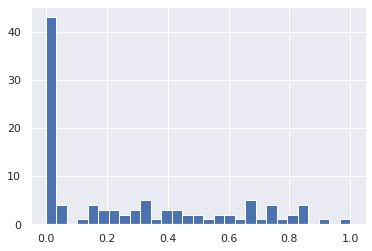

In [191]:
numbins = np.linspace(0, 1, 30)
plt.hist(deltas_chems_stats['p_values'], bins = numbins)
plt.plot()

### METABOLOMICS

In [192]:
metabolomics = adi.get_snapshot('metabolomics_corrected')
metabolomics_rmdups = metabolomics.drop_duplicates(subset = ['public_client_id'], keep='first')

deltas_metabolomics_bulk = pd.merge(deltas_alone, metabolomics_rmdups, on=['public_client_id'])
deltas_metabolomics_tot = deltas_metabolomics_bulk.drop(['sample_id', 'days_in_program', 'days_since_first_call',
                                                     'days_since_first_draw', 'month', 'weekday', 'season'], axis=1)

no_use_metabs = deltas_metabolomics_tot.columns[deltas_metabolomics_tot.isnull().mean()>0.95]
deltas_metabolomics = deltas_metabolomics_tot.drop(no_use_metabs, axis=1)

list_of_metab_metrics = list(deltas_metabolomics_bulk.columns.values)
deltas_metabolomics.head(n=5)

,public_client_id,Normal Delta,35,50,55,62,71,93,98,111,...,999953114,999953157,999953172,999953266,999953267,999954831,999954832,999954834,999954839,999954840
0,01005890,-0.202091,1.226609,2.054914,0.699782,NaN,NaN,1.102510,0.790515,0.595709,...,0.589165,1.260208,NaN,0.141653,2.404176,1.138582,1.349721,1.284940,NaN,NaN
1,01006974,0.032604,0.768885,4.983207,1.521427,1.136869,1.623994,0.339664,1.099376,1.056021,...,0.788866,0.861376,0.910897,1.512606,1.202112,1.249965,1.676823,1.517884,0.815230,0.531682
2,01008097,-0.916777,0.873870,1.042338,1.577632,0.341082,NaN,1.100104,0.845862,2.139175,...,NaN,NaN,0.959416,1.409062,1.019269,NaN,NaN,NaN,NaN,0.982741
3,01011802,0.217705,NaN,4.109130,3.099068,3.361333,0.893886,1.677952,0.615265,0.766453,...,0.548295,0.590373,1.239580,1.177106,1.276388,NaN,NaN,NaN,NaN,NaN
4,01013950,-0.152356,0.645524,NaN,1.185702,3.920856,NaN,0.801543,0.944231,1.833695,...,0.507026,0.773996,1.559200,0.834728,1.030811,0.959803,0.912195,0.909565,0.570632,NaN


In [193]:
p_values = []
rho_values = []

for i in range(deltas_metabolomics.shape[1] - 2):
    spearman = stats.spearmanr(deltas_metabolomics.iloc[:, 0], deltas_metabolomics.iloc[:, i+2])

    
    p_values.append(spearman[1])
    rho_values.append(spearman[0])
    
deltas_metab_stats = pd.DataFrame()
metrics = list(deltas_metabolomics.columns.values)

p_series = pd.Series(p_values)
rho_series = pd.Series(rho_values)
metrics_series = pd.Series(metrics[2:len(metrics)])

deltas_metab_stats['metric'] = metrics_series.values
deltas_metab_stats['rho_values'] = rho_series.values
deltas_metab_stats['p_values'] = p_series.values

FDR = sm.stats.multitest.multipletests(deltas_metab_stats['p_values'], alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)

deltas_metab_stats['FDR'] = pd.Series(FDR[1])

metab_norm_test = deltas_metabolomics.drop(['public_client_id', 'Normal Delta'], axis=1)
z, norm_pval = stats.normaltest(metab_norm_test, axis=0, nan_policy='omit')

deltas_metab_stats['norm_stat'] = z
deltas_metab_stats['normtest_pval'] = norm_pval

deltas_metab_stats_sorted = deltas_metab_stats.sort_values(by=['FDR'])
# pd.set_option('display.max_rows', None)
deltas_metab_stats_sorted.head(n=20)

,metric,rho_values,p_values,FDR,norm_stat,normtest_pval
117,913,-0.751205,4.603018e-56,5.712345e-53,101.759518,8.002052e-23
545,100002953,-0.748790,1.598491e-55,9.918638e-53,132.555281,1.644321e-29
165,1239,-0.744615,1.330752e-54,5.504876e-52,126.710927,3.055426e-28
900,100019982,-0.732749,4.416818e-52,1.370318e-49,588.150032,1.926829e-128
1019,999946409,-0.727344,5.610931e-51,1.392633e-48,59.912818,9.774551e-14
60,363,-0.725912,1.089209e-50,2.252848e-48,118.384367,1.964090e-26
57,356,-0.724745,1.864090e-50,3.304765e-48,28.591816,6.185374e-07
1130,999947671,-0.723763,2.923788e-50,4.535527e-48,108.712788,2.473535e-24
422,100001655,-0.721730,7.379353e-50,1.017531e-47,118.683609,1.691148e-26
576,100003686,-0.721139,9.643961e-50,1.187178e-47,136.056874,2.855125e-30


[]

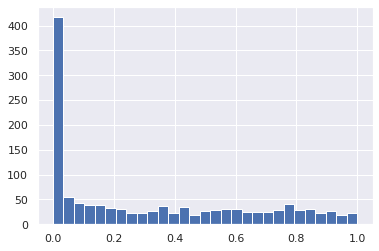

In [194]:
plt.hist(deltas_metab_stats['p_values'], bins = numbins)
plt.plot()

### MICROBIOME DIVERSITY

In [195]:
microbiome_diversity = adi.get_snapshot('microbiome_diversity')
microbiome_diversity_rmdups = microbiome_diversity.drop_duplicates(subset = ['public_client_id'], keep='first')

# microbiome_otus = adi.get_snapshot('microbiome_otus')
# microbiome_otus_rmdups = microbiome_otus.drop_duplicates(subset = ['public_client_id'], keep='first')

# microb_deltas_dataframes = [deltas_alone, microbiome_diversity]
# deltas_microb_bulk = reduce(lambda left, right: pd.merge(left, right, on='public_client_id'), microb_deltas_dataframes)

deltas_microb_bulk = pd.merge(deltas_alone, microbial_diversity_rmdups, on=['public_client_id'])

deltas_microbiomes_tot = deltas_microb_bulk.drop(['vendor_observation_id', 'vendor_dashboard', 'client_id', 'vendor_research',
                                              'days_in_program', 'days_since_first_call', 'days_since_first_draw', 'month',
                                              'weekday', 'season'], axis=1)

no_use_microbes = deltas_microbiomes_tot.columns[deltas_microbiomes_tot.isnull().mean()>0.95]
deltas_microbiomes = deltas_microbiomes_tot.drop(no_use_microbes, axis=1)

list_of_microb_metrics = list(deltas_microb_bulk.columns.values)
deltas_microbiomes.head(n=5)

,public_client_id,Normal Delta,MICROBIOME_DIVERSITY_SCORE,diversity_PD_whole_tree,diversity_chao1,diversity_observed_otus,diversity_shannon,diversity_simpson,PD_whole_tree_100000,PD_whole_tree_20000,...,observed_otus_30000,observed_otus_50000,shannon_100000,shannon_20000,shannon_30000,shannon_50000,simpson_100000,simpson_20000,simpson_30000,simpson_50000
0,01005100,0.167630,NaN,29.692,829.685,491.9,3.127480,0.882,35.977,22.881,...,389.7,491.9,3.133025,3.119855,3.123321,3.127480,0.882,0.882,0.882,0.882
1,01005890,-0.202091,3.506839,NaN,NaN,NaN,3.506839,NaN,50.287,32.982,...,733.8,890.1,3.925986,3.894794,3.912816,3.921134,0.952,0.952,0.952,0.952
2,01006974,0.032604,3.584385,NaN,NaN,NaN,3.584385,NaN,59.346,37.677,...,821.3,1036.2,3.876079,3.847660,3.853205,3.865682,0.924,0.924,0.924,0.924
3,01008097,-0.916777,NaN,41.164,1043.010,683.8,3.895487,0.949,NaN,32.913,...,555.6,683.8,NaN,3.883704,3.887169,3.895487,NaN,0.949,0.949,0.949
4,01011802,0.217705,3.246263,NaN,NaN,NaN,3.246263,NaN,48.847,31.554,...,707.5,860.8,3.646647,3.627932,3.634171,3.643182,0.920,0.920,0.920,0.921


In [196]:
p_values = []
rho_values = []

for i in range(deltas_microbiomes.shape[1] - 2):
    spearman = stats.spearmanr(deltas_microbiomes.iloc[:, 0], deltas_microbiomes.iloc[:, i+2], nan_policy='omit')
    
    p_values.append(spearman[1])
    rho_values.append(spearman[0])
    
deltas_microb_stats = pd.DataFrame()
metrics = list(deltas_microbiomes.columns.values)

p_series = pd.Series(p_values)
rho_series = pd.Series(rho_values)
metrics_series = pd.Series(metrics[2:len(metrics)])

deltas_microb_stats['metric'] = metrics_series.values
deltas_microb_stats['rho_values'] = rho_series.values
deltas_microb_stats['p_values'] = p_series.values

FDR = sm.stats.multitest.multipletests(deltas_microb_stats['p_values'], alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)

deltas_microb_stats['FDR'] = pd.Series(FDR[1])

microb_norm_test = deltas_microbiomes.drop(['public_client_id', 'Normal Delta'], axis=1)
z, norm_pval = stats.normaltest(microb_norm_test, axis=0, nan_policy='omit')

deltas_microb_stats['norm_stat'] = z
deltas_microb_stats['normtest_pval'] = norm_pval

deltas_microb_stats_sorted = deltas_microb_stats.sort_values(by=['FDR'])
# pd.set_option('display.max_rows', None)
deltas_microb_stats_sorted.head(n=15)

,metric,rho_values,p_values,FDR,norm_stat,normtest_pval
0,MICROBIOME_DIVERSITY_SCORE,-0.598844,2.394072e-38,6.224587e-37,23.168632,9.310982e-06
1,diversity_PD_whole_tree,-0.307238,9.473318e-10,1.231531e-08,4.272883,1.180743e-01
3,diversity_observed_otus,-0.153546,2.689909e-03,2.331254e-02,6.764786,3.396607e-02
2,diversity_chao1,-0.144720,4.702823e-03,3.056835e-02,7.287414,2.615520e-02
18,shannon_100000,-0.133742,9.047528e-03,4.704715e-02,56.952748,4.294058e-13
22,simpson_100000,-0.110645,3.105288e-02,1.345625e-01,241.298843,4.005179e-53
5,diversity_simpson,-0.106163,3.858963e-02,1.433329e-01,151.084446,1.557505e-33
6,PD_whole_tree_100000,-0.101530,4.795293e-02,1.558470e-01,13.901748,9.577977e-04
10,chao1_100000,-0.092575,7.145996e-02,2.064399e-01,2.487289,2.883315e-01
14,observed_otus_100000,-0.077989,1.291160e-01,3.357017e-01,35.758122,1.718789e-08


[]

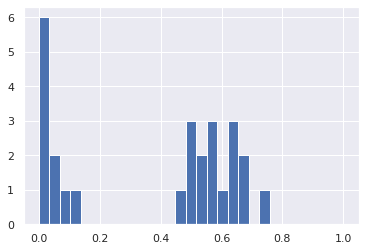

In [197]:
plt.hist(deltas_microb_stats['p_values'], bins = numbins)
plt.plot()

### PROTEOMICS

In [198]:
proteomics = adi.get_snapshot('proteomics_corrected')
proteomics_rmdups = proteomics.drop_duplicates(subset = ['public_client_id'], keep='first')

deltas_proteomics_bulk = pd.merge(deltas_alone, proteomics_rmdups, on=['public_client_id'])
deltas_proteomics_tot = deltas_proteomics_bulk.drop(['sample_id', 'Chip_ID_CAM', 'Chip_ID_CRE', 'Chip_ID_CVD2', 'Chip_ID_CVD3',
                                                     'Chip_ID_DEV', 'Chip_ID_INF', 'Chip_ID_IRE', 'Chip_ID_MET', 'Chip_ID_NEU1',
                                                     'Chip_ID_NEX', 'Chip_ID_ODA', 'Chip_ID_ONC2', 'Chip_ID_ONC3', 'days_in_program',
                                                     'days_since_first_call', 'days_since_first_draw', 'month', 'weekday', 'season'], axis=1)
no_use_proteo = deltas_proteomics_tot.columns[deltas_proteomics_tot.isnull().mean()>0.95]
deltas_proteomics = deltas_proteomics_tot.drop(no_use_proteo, axis=1)

list_of_proteo_metrics = list(deltas_proteomics_bulk.columns.values)
deltas_proteomics.head(n=5)

,public_client_id,Normal Delta,CAM_O00533,CAM_O14786,CAM_O15031,CAM_O75015,CAM_O75023,CAM_O95445,CAM_P00441,CAM_P00915,...,ONC3_Q9NTU7,ONC3_Q9P1Z2,ONC3_Q9UDT6,ONC3_Q9UHD8,ONC3_Q9UJY5,ONC3_Q9UMF0,ONC3_Q9Y2B0,ONC3_Q9Y5K2,ONC3_Q9Y5K8,ONC3_Q9Y644
0,01005890,-0.202091,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,01006974,0.032604,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,01008097,-0.916777,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,01011802,0.217705,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,01013950,-0.152356,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [199]:
p_values = []
rho_values = []

for i in range(deltas_proteomics.shape[1] - 2):
    spearman = stats.spearmanr(deltas_proteomics.iloc[:, 0], deltas_proteomics.iloc[:, i+2], nan_policy='omit')
    
    p_values.append(spearman[1])
    rho_values.append(spearman[0])
    
deltas_proteo_stats = pd.DataFrame()
metrics = list(deltas_proteomics.columns.values)

p_series = pd.Series(p_values)
rho_series = pd.Series(rho_values)
metrics_series = pd.Series(metrics[2:len(metrics)])

deltas_proteo_stats['metric'] = metrics_series.values
deltas_proteo_stats['rho_values'] = rho_series.values
deltas_proteo_stats['p_values'] = p_series.values

FDR = sm.stats.multitest.multipletests(deltas_proteo_stats['p_values'], alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)

deltas_proteo_stats['FDR'] = pd.Series(FDR[1])

proteo_norm_test = deltas_proteomics.drop(['public_client_id', 'Normal Delta'], axis=1)
z, norm_pval = stats.normaltest(proteo_norm_test, axis=0, nan_policy='omit')

deltas_proteo_stats['norm_stat'] = z
deltas_proteo_stats['normtest_pval'] = norm_pval

deltas_proteo_stats_sorted = deltas_proteo_stats.sort_values(by=['FDR'])
# pd.set_option('display.max_rows', None)
deltas_proteo_stats_sorted.head(n=20)

,metric,rho_values,p_values,FDR,norm_stat,normtest_pval
478,INF_P01732,-0.610499,1.352321e-35,1.274148e-32,4.515103,0.104606
360,CVD3_Q9HCN6,-0.609098,2.132465e-35,1.274148e-32,6.445248,0.039850
0,CAM_O00533,-0.576206,5.024480e-31,6.957465e-31,0.060139,0.970378
799,NEU1_Q8N126,-0.576629,4.446512e-31,6.957465e-31,0.558317,0.756420
798,NEU1_Q8IUN9,-0.576621,4.455968e-31,6.957465e-31,0.318567,0.852755
797,NEU1_Q6ZMJ2,-0.576536,4.566783e-31,6.957465e-31,0.183700,0.912242
796,NEU1_Q6UX15,-0.576399,4.752146e-31,6.957465e-31,1.362607,0.505957
795,NEU1_Q6NW40,-0.576556,4.540294e-31,6.957465e-31,1.919534,0.382982
794,NEU1_Q6ISS4,-0.576585,4.502300e-31,6.957465e-31,0.763449,0.682683
793,NEU1_Q2VWP7,-0.576536,4.566783e-31,6.957465e-31,4.383901,0.111699


[]

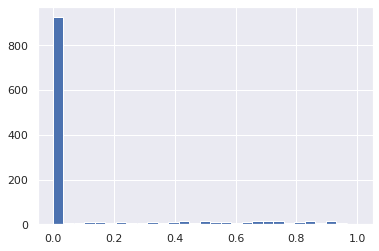

In [200]:
plt.hist(deltas_proteo_stats['p_values'], bins = numbins)
plt.plot()

### HEALTH METRICS

In [201]:
blood_pressure = adi.get_snapshot('blood_pressure')
blood_pressure_rmdups = blood_pressure.drop_duplicates(subset = ['public_client_id'], keep='first')

saliva = adi.get_snapshot('saliva')
saliva_rmdups = saliva.drop_duplicates(subset = ['public_client_id'], keep='first')

weight = adi.get_snapshot('weight')
weight_rmdups = weight.drop_duplicates(subset = ['public_client_id'], keep='first')

# storing all dataframes in a list to iterate through so I can merge them all
deltas_health_dataframes = [deltas_alone, blood_pressure_rmdups, saliva_rmdups, weight_rmdups]

# merging all genetics data files on deltas_alone on public_client_id
deltas_health_bulk = reduce(lambda left, right: pd.merge(left, right, on='public_client_id'), deltas_health_dataframes)

deltas_health_tot = deltas_health_bulk.drop(['vendor_x', 'days_in_program_x', 'days_since_first_call_x', 'days_since_first_draw_x',
                                         'month_x', 'weekday_x', 'season_x', 'vendor_x', 'vendor_y', 'days_in_program_y',
                                         'days_since_first_call_y', 'days_since_first_draw_y', 'month_y', 'weekday_y',
                                         'season_y', 'vendor', 'days_in_program', 'days_since_first_call', 
                                         'days_since_first_draw', 'month', 'weekday', 'season'], axis=1)
no_use_health = deltas_health_tot.columns[deltas_health_tot.isnull().mean()>0.95]
deltas_health = deltas_health_tot.drop(no_use_health, axis=1)

health_metrics = list(deltas_health.columns.values)
# pd.set_option('display.max_rows', None)
deltas_health.head(n=5)

,public_client_id,Normal Delta,MEAN_ARTERIAL_BLOOD_PRESSURE,PULSE_PRESSURE,diastolic,heart_rate,systolic,CORTISOL_EVENING,CORTISOL_MORNING,CORTISOL_NIGHT,CORTISOL_NOON,CORTISOL_OVER_DAY,DHEA,client_id,observation_id,WEIGHT_CALC,HEIGHT_CALC,BMI_CALC,waist_circumference
0,01005890,-0.202091,84.000000,36.0,72.0,NaN,108.0,1.7,9.4,0.6,6.1,83.333333,3.3,135726.0,514324.0,143.0,66.0,23.078283,NaN
1,01006974,0.032604,90.666667,32.0,80.0,56.0,112.0,NaN,8.3,2.9,4.6,80.000000,2.0,327.0,2381067.0,176.0,71.0,24.544336,NaN
2,01008097,-0.916777,91.000000,57.0,72.0,NaN,129.0,1.2,10.2,1.2,3.8,16.666667,3.2,164967.0,1032988.0,232.0,72.0,31.461420,NaN
3,01011802,0.217705,82.000000,30.0,72.0,64.0,102.0,1.7,5.6,0.9,2.0,100.000000,6.9,736.0,7823.0,134.0,66.0,21.625803,NaN
4,01013950,-0.152356,96.666667,38.0,84.0,64.0,122.0,8.1,15.5,2.4,4.6,50.000000,4.5,490.0,5043.0,135.0,64.0,23.170166,NaN


In [202]:
p_values = []
rho_values = []

for i in range(deltas_health.shape[1] - 2):
    spearman = stats.spearmanr(deltas_health.iloc[:, 0], deltas_health.iloc[:, i+2], nan_policy='omit')
    
    p_values.append(spearman[1])
    rho_values.append(spearman[0])
    
deltas_health_stats = pd.DataFrame()
metrics = list(deltas_health.columns.values)

p_series = pd.Series(p_values)
rho_series = pd.Series(rho_values)
metrics_series = pd.Series(metrics[2:len(metrics)])

deltas_health_stats['metric'] = metrics_series.values
deltas_health_stats['rho_values'] = rho_series.values
deltas_health_stats['p_values'] = p_series.values

FDR = sm.stats.multitest.multipletests(deltas_health_stats['p_values'], alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)

deltas_health_stats['FDR'] = pd.Series(FDR[1])

health_norm_test = deltas_health.drop(['public_client_id', 'Normal Delta'], axis=1)
z, norm_pval = stats.normaltest(health_norm_test, axis=0, nan_policy='omit')

deltas_health_stats['norm_stat'] = z
deltas_health_stats['normtest_pval'] = norm_pval

deltas_health_stats_sorted = deltas_health_stats.sort_values(by=['FDR'])
# pd.set_option('display.max_rows', None)
deltas_health_stats_sorted.head(n=20)

,metric,rho_values,p_values,FDR,norm_stat,normtest_pval
1,PULSE_PRESSURE,-0.733850,3.030450e-61,5.151765e-60,10.741479,4.650690e-03
0,MEAN_ARTERIAL_BLOOD_PRESSURE,-0.708928,1.769407e-55,1.503996e-54,37.195481,8.377297e-09
10,DHEA,-0.659077,1.341483e-45,7.601735e-45,76.380356,2.595473e-17
3,heart_rate,-0.602186,2.094987e-36,8.903694e-36,8.380372,1.514347e-02
16,waist_circumference,-0.577377,6.029444e-33,2.050011e-32,2.131062,3.445448e-01
2,diastolic,0.149932,4.640368e-03,1.126946e-02,17.037137,1.997252e-04
4,systolic,0.152211,4.046425e-03,1.126946e-02,27.754044,9.403423e-07
13,WEIGHT_CALC,0.096156,7.037080e-02,1.495380e-01,18.623013,9.037827e-05
15,BMI_CALC,0.090944,8.707864e-02,1.644819e-01,53.556913,2.345655e-12
7,CORTISOL_NIGHT,0.068157,2.001433e-01,3.402436e-01,183.728925,1.269904e-40


[]

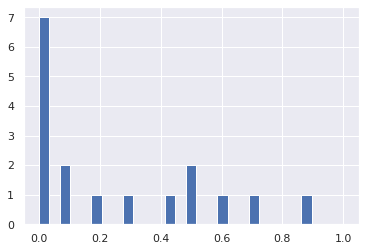

In [203]:
plt.hist(deltas_health_stats['p_values'], bins = numbins)
plt.plot()

### Conglomerate all omics

In [204]:
deltas_all_omics_dataframes = [deltas_alone, deltas_chemistries, deltas_metabolomics, 
                               deltas_microbiomes, deltas_proteomics, deltas_health]

deltas_all_omics = reduce(lambda left, right: pd.merge(left, right, on='public_client_id'), deltas_all_omics_dataframes)
deltas_all_omics = deltas_all_omics.drop(['Normal Delta_y', 'GLYCOHEMOGLOBIN A1C', 'observation_id', 'GLUCOSE', 
                                         'HOMA-IR', 'INSULIN', '100002405'], axis=1)
deltas_all_omics = deltas_all_omics.rename(columns={'Normal Delta_x':'Normal Delta'})
deltas_all_omics = deltas_all_omics.drop(['Normal Delta'], axis=1)
deltas_all_omics = pd.merge(deltas_all_omics, deltas_alone, on=['public_client_id'])
deltas_all_omics = deltas_all_omics.fillna(0)
deltas_all_omics.to_csv('deltas_all_omics.csv', index = False)
# pd.set_option('display.max_rows', None)
deltas_all_omics

,public_client_id,A/G RATIO,"ADIPONECTIN, SERUM",ALAT (SGPT),ALBUMIN,ALKALINE PHOSPHATASE,"ANTIOXID CAP, TOTAL",ARACHIDONIC ACID,"ARSENIC, BLOOD",ASAT (SGOT),...,CORTISOL_NIGHT,CORTISOL_NOON,CORTISOL_OVER_DAY,DHEA,client_id,WEIGHT_CALC,HEIGHT_CALC,BMI_CALC,waist_circumference,Normal Delta
0,01005890,1.8,6.4,18.0,4.4,56.0,0.0,9.8,0.0,23.0,...,0.6,6.1,83.333333,3.3,135726.0,143.0,66.0,23.078283,0.0,-0.202091
1,01006974,2.0,10.1,18.0,4.3,41.0,993.6,0.2,2.0,22.0,...,2.9,4.6,80.000000,2.0,327.0,176.0,71.0,24.544336,0.0,0.032604
2,01008097,2.4,4.9,20.0,4.5,61.0,0.0,11.9,0.0,19.0,...,1.2,3.8,16.666667,3.2,164967.0,232.0,72.0,31.461420,0.0,-0.916777
3,01011802,1.4,9.1,17.0,4.2,64.0,837.5,7.4,2.0,22.0,...,0.9,2.0,100.000000,6.9,736.0,134.0,66.0,21.625803,0.0,0.217705
4,01013950,1.7,12.6,21.0,4.6,55.0,1059.1,8.9,3.0,20.0,...,2.4,4.6,50.000000,4.5,490.0,135.0,64.0,23.170166,0.0,-0.152356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,01982074,1.6,5.7,13.0,4.2,53.0,0.0,11.5,0.0,14.0,...,0.7,3.1,83.333333,0.0,197156.0,180.0,64.0,30.893555,0.0,2.324168
290,01982352,1.5,1.5,28.0,4.3,67.0,0.0,7.0,0.0,32.0,...,0.6,2.0,100.000000,13.3,162638.0,220.0,75.0,27.495111,0.0,-1.076600
291,01986408,2.0,14.3,29.0,4.1,62.0,0.0,10.0,0.0,24.0,...,2.5,1.8,66.666667,4.4,162426.0,207.0,64.0,35.527588,0.0,-1.076600
292,01994330,2.3,4.4,13.0,4.6,49.0,1627.2,5.9,6.0,19.0,...,2.6,3.9,66.666667,1.9,416.0,207.0,73.0,27.307375,0.0,-0.546886


##### Copying LASSO script from Tom to run it here, rather than exporting a cvs and importing it somewhere else

In [205]:
# Load libraries
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn import model_selection
import seaborn as sns
from string import ascii_letters
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV,LassoCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [206]:
#Importing csv containing deltas and all omics
deltas_all_omics=pd.read_csv('deltas_all_omics.csv')
#set index
deltas_all_omics.set_index('public_client_id',inplace=True)
deltas_all_omics.index=deltas_all_omics.index.astype('float64')
#check shape of df
print (deltas_all_omics.shape)

(294, 2578)


(294, 2577)
AxesSubplot(0.125,0.125;0.775x0.755)


,A/G RATIO,"ADIPONECTIN, SERUM",ALAT (SGPT),ALBUMIN,ALKALINE PHOSPHATASE,"ANTIOXID CAP, TOTAL",ARACHIDONIC ACID,"ARSENIC, BLOOD",ASAT (SGOT),BASOPHILS,...,CORTISOL_MORNING,CORTISOL_NIGHT,CORTISOL_NOON,CORTISOL_OVER_DAY,DHEA,client_id,WEIGHT_CALC,HEIGHT_CALC,BMI_CALC,waist_circumference
0,-0.065409,-0.512994,-0.304793,-0.080395,-0.453219,-0.867539,0.207977,-0.753385,0.252627,1.092646,...,1.058981,-0.714272,2.303400,0.198469,0.041953,0.461217,-0.714144,-0.052502,-0.644115,-0.3574
1,0.719500,0.144368,-0.304793,-0.461622,-1.119451,0.711889,-3.360381,0.440659,0.108688,-0.263742,...,0.641991,1.348910,1.271083,0.055367,-0.268193,-1.067295,0.074616,0.596050,-0.400285,-0.3574
2,2.289320,-0.779492,-0.150428,0.300832,-0.231142,-0.867539,0.988556,-0.753385,-0.323127,1.092646,...,1.362247,-0.176051,0.720515,-2.663577,0.018096,0.791317,1.413117,0.725760,0.750144,-0.3574
3,-1.635228,-0.033297,-0.381976,-0.842849,-0.097895,0.463752,-0.684112,0.440659,0.108688,-0.263742,...,-0.381532,-0.445162,-0.518265,0.913981,0.900819,-1.062678,-0.929260,-0.052502,-0.885688,-0.3574
4,-0.457864,0.588532,-0.073245,0.682059,-0.497635,0.816008,-0.126556,1.037682,-0.179189,0.414452,...,3.371385,0.900392,1.271083,-1.232554,0.328242,-1.065455,-0.905358,-0.311923,-0.628834,-0.3574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,-0.850319,-0.637360,-0.690707,-0.842849,-0.586465,-0.867539,0.839874,-0.753385,-1.042819,1.092646,...,-0.988065,-0.624569,0.238767,0.198469,-0.745340,1.154697,0.170223,-0.311923,0.655699,-0.3574
290,-1.242774,-1.383555,0.467034,-0.461622,0.035351,-0.867539,-0.832794,-0.753385,1.548073,1.092646,...,-0.040358,-0.714272,-0.518265,0.913981,2.427690,0.765025,1.126295,1.114892,0.090479,-0.3574
291,0.719500,0.890563,0.544217,-1.224076,-0.186726,-0.867539,0.282318,-0.753385,0.396565,1.092646,...,0.035458,0.990095,-0.655907,-0.517042,0.304384,0.762632,0.815572,-0.311923,1.426418,-0.3574
292,1.896865,-0.868325,-0.690707,0.682059,-0.764127,1.719061,-1.241668,2.828749,-0.323127,-0.037677,...,-1.291331,1.079799,0.789336,-0.517042,-0.292050,-1.066290,0.815572,0.855471,0.059255,-0.3574


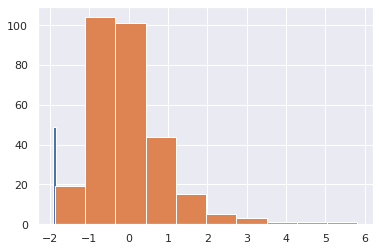

In [207]:
#Scale and standardize omics (columns 0-2585)
X = deltas_all_omics[deltas_all_omics.columns[0:2577]]
#define the dependent variable (normalized deltas)
y = (deltas_all_omics['Normal Delta'])
#scale and standardize
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
Xcolumns=X.columns
X = scaler.fit_transform(X)
X=pd.DataFrame(data=X,columns=Xcolumns)
print (X.shape)
sns.set(font_scale=1.00)
#test scaling
print (X['chao1_100000'].hist(bins=50))
#plot histogram of outcome variable deltas
plt.hist(y)
X

In [208]:
## run cross_val_score on ridge and lasso to get out-of-sample R2 scores across 10-CV
#This is pretty much the sklearn version doing what my code is doing in the cell below.
#defining L2 parameters to be tested
alphas = np.linspace(1,1000,200)
#Defining LASSO and Ridge parameters
#alphas are the tuning parameters tested by the algorithm, epse is a ratio of the lowest to highest alpha, provding
#a range for where the algorithm should focus the search
#Since the dependent variable was not scaled and standardized we also fit an intercept
lassocv=LassoCV(eps=0.175, n_alphas=200, alphas=None, fit_intercept=True, normalize=False, precompute='auto', cv=10)
ridgecv=RidgeCV(alphas=alphas,fit_intercept=True,normalize=False,cv=10)
#Running 10-fold CV score function to get mean out-of-sample R2
discovery_score=cross_val_score(lassocv,X,y,cv=10)
print ('mean out-of-sample R2 LASSO',np.mean(discovery_score))
discovery_score_ridge=cross_val_score(ridgecv,X,y,cv=10)
print ('mean out-of-sample R2 Ridge',np.mean(discovery_score_ridge))

mean out-of-sample R2 LASSO -0.0529063703296551
mean out-of-sample R2 Ridge 0.006046394361522378


In [209]:
#Run Cross-validation and extract Beta_coefficients for each model
#this is pretty much replicating the analysis above, but extracting different variables along the way
#Save predictions from each test set
lassocv=LassoCV(eps=0.175, n_alphas=200, alphas=None, fit_intercept=True, normalize=False, precompute='auto', cv=10)
y=deltas_all_omics['Normal Delta']
y=y.reset_index()
y.drop(['public_client_id'],1,inplace=True)
#split data into ten sets
X_folds = np.array_split(X, 10)
y_folds = np.array_split(y, 10)
#create a dataframe here coefficients for each metabolite will be stored
coefficients=pd.DataFrame(index=X.columns).astype('float64')
#lists for other variables extracted from the 10-fold CV
predictions=[]
alphas= []
score= []
#perform the 10-fold CV scheme to predict the normalized deltas from all other omics
for k in range(10):
    X_train = list(X_folds)
    X_test  = X_train.pop(k)
    X_train = np.concatenate(X_train)
    y_train = list(y_folds)
    y_test  = y_train.pop(k)
    y_test=[ x[0] for x in  list(y_test.values)]
    y_train = np.concatenate(y_train)
    lassocv.fit(X_train, y_train)
    predictions.append(lassocv.predict(X_test).flatten())
    coef=list(lassocv.coef_)
    coefficients[k]=coef
    alphas.append(lassocv.alpha_)
    score.append(r2_score(y_test,lassocv.predict(X_test)))
#print The L1 penalty for each model
print (alphas)
predictions_lasso=[item for sublist in predictions for item in sublist]
#Checking r2 score and pearson r
print ('mean R2 Score LASSO',np.mean(score))
print ('std. deviation for R2 Score',np.std(score))
print ('S.E.M',np.std(score)/np.sqrt(10))
print ('observed v predicted pearson r',stats.pearsonr(deltas_all_omics['Normal Delta'],predictions_lasso))

[0.14012077213313393, 0.3265192709949801, 0.33498597930210877, 0.27488336899973337, 0.10448172210292228, 0.37405484949560625, 0.15554077384794734, 0.1760180968668322, 0.06664871557036517, 0.06709808561364919]
mean R2 Score LASSO -0.0529063703296551
std. deviation for R2 Score 0.0937432717970076
S.E.M 0.02964422541947696
observed v predicted pearson r (0.03455731781796516, 0.5550655160768233)


In [210]:
score

[-0.15655325240315765,
 -0.01124451062015841,
 -0.004486333537707443,
 -0.01188215338252463,
 -0.016418579606208406,
 -0.00017373081870997176,
 -0.13178659697401307,
 -0.01209762044754914,
 0.07554379097588226,
 -0.2599647164824046]

In [211]:
#generate dataframe with out-of-sampe predictions for each person
predictions=pd.DataFrame(index=deltas_all_omics.index)
predictions['predictions']=predictions_lasso
predictions['Normal Delta']=deltas_all_omics['Normal Delta']
predictions.to_csv("predictions.csv")

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


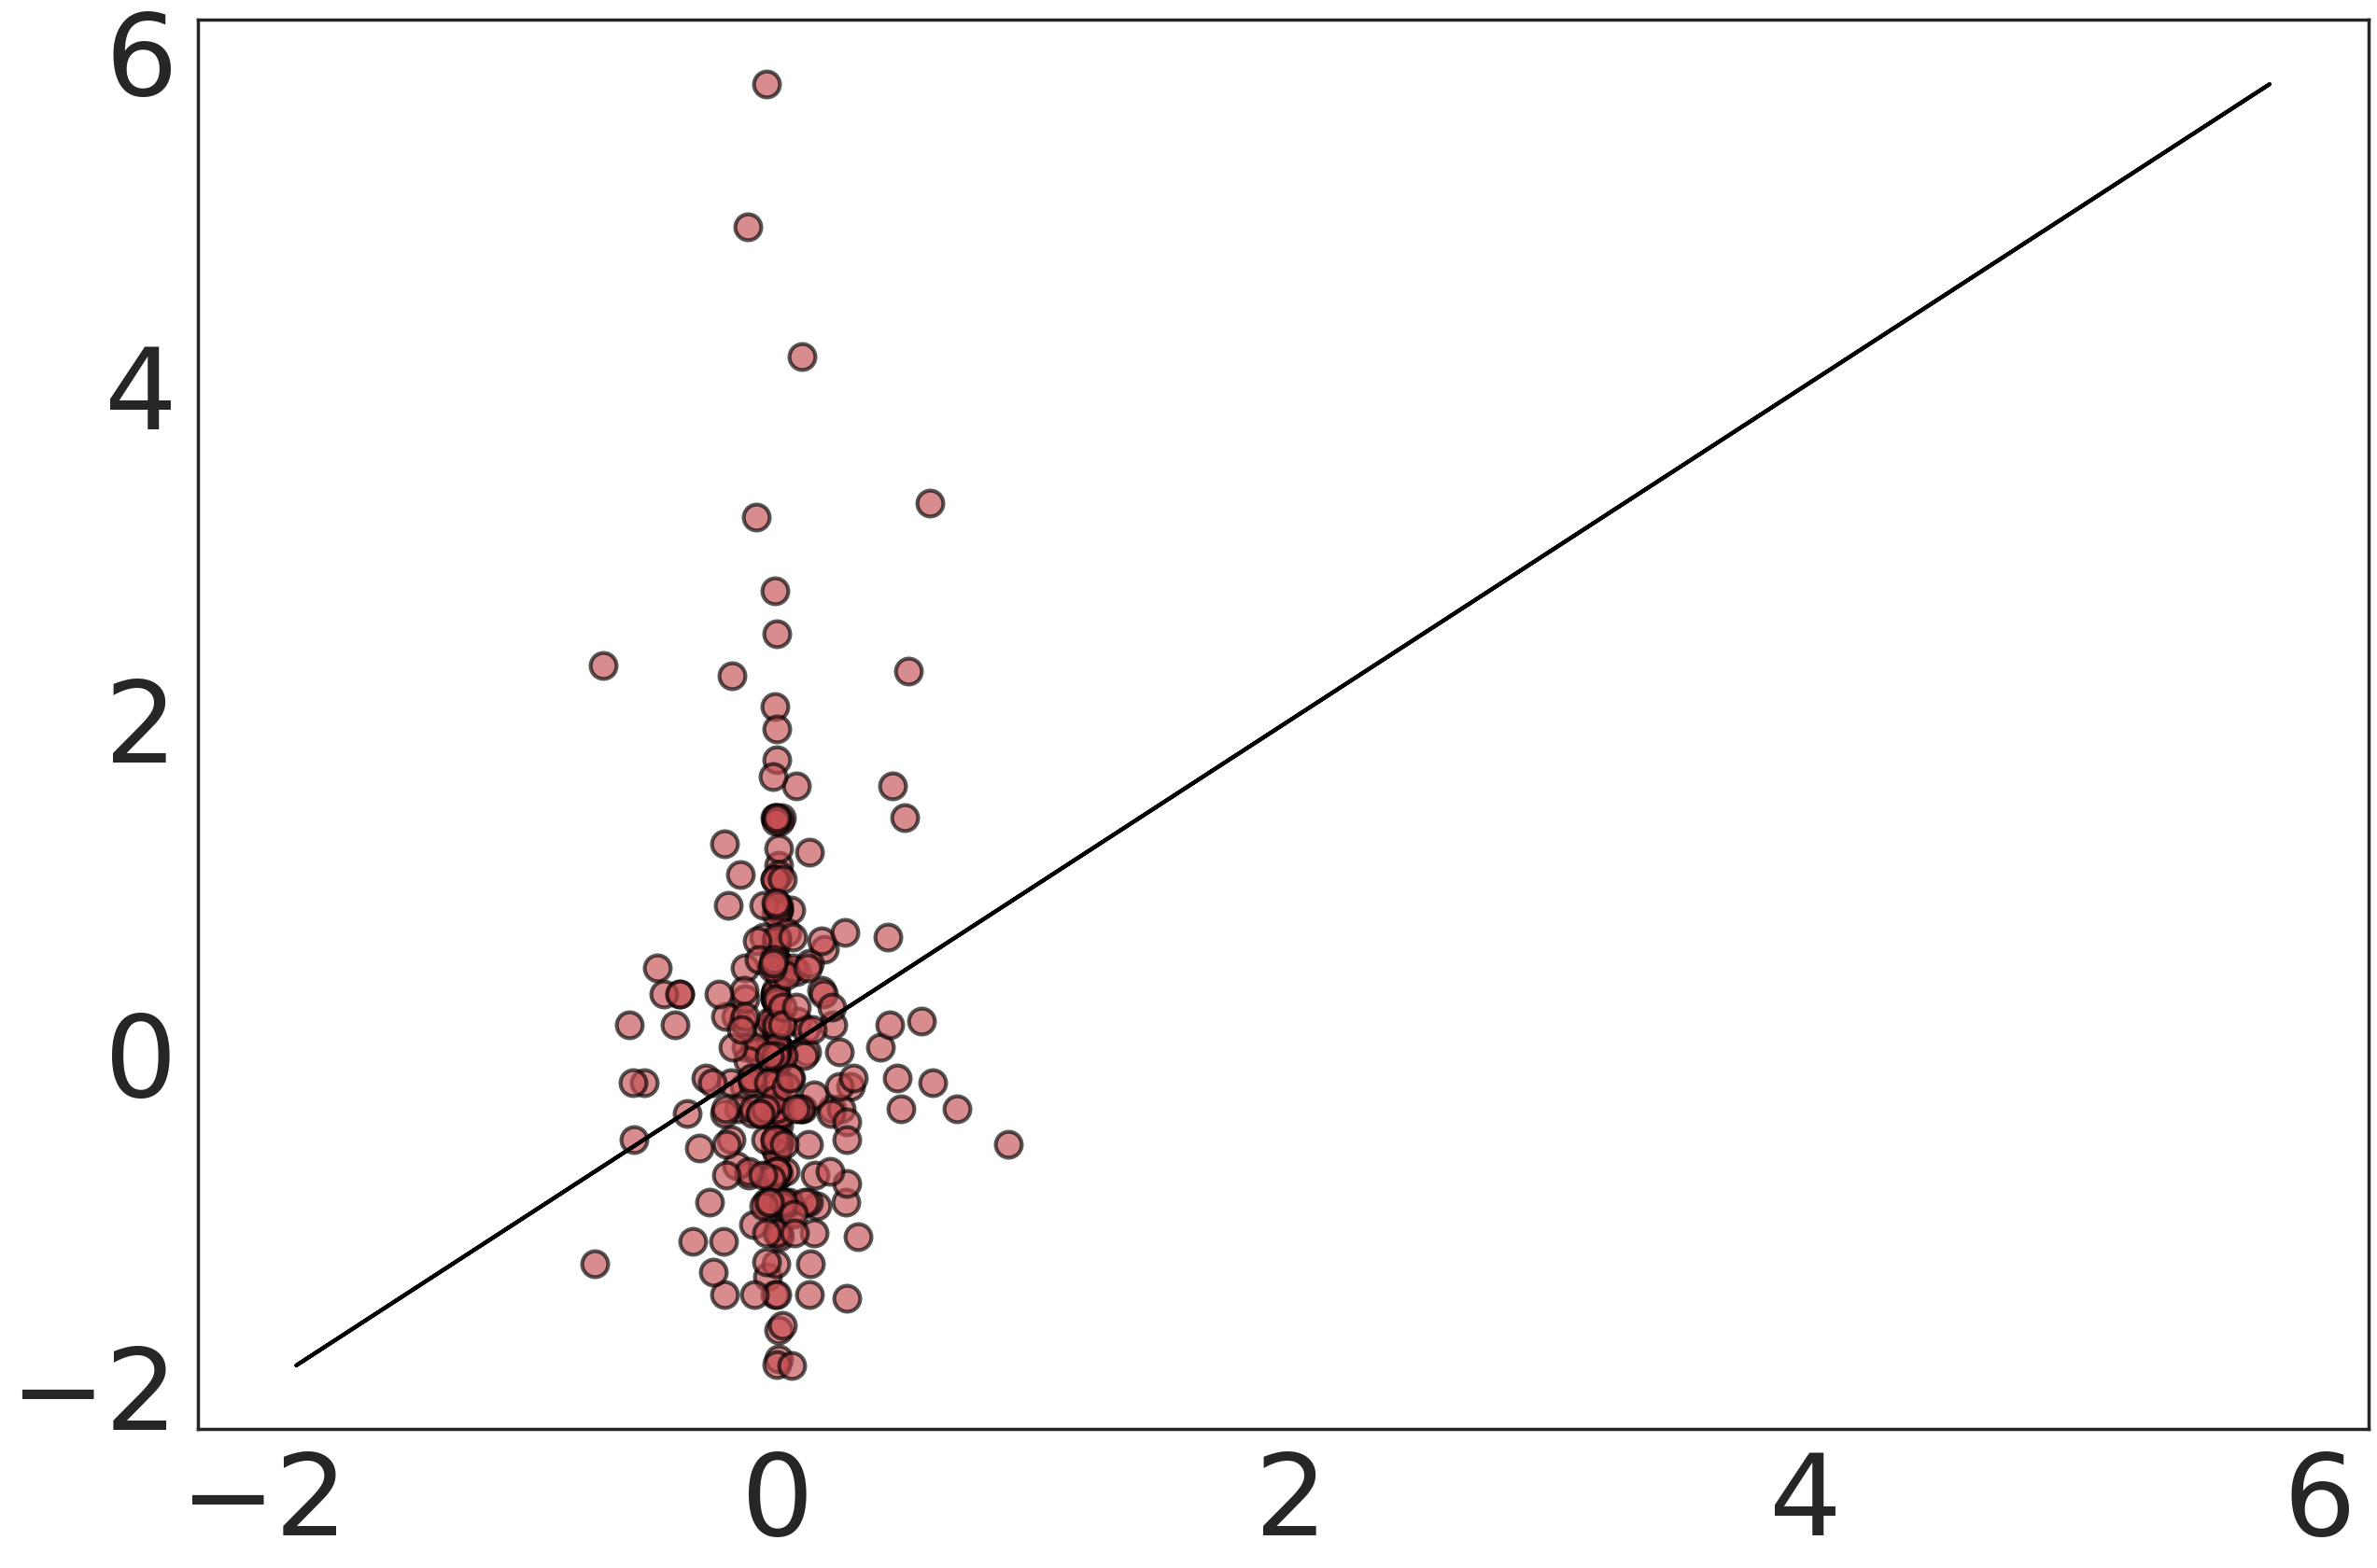

In [212]:
sns.set(font_scale=4.00,context='poster',font='Arial',style='white')
plt.figure(figsize=[30,20], dpi=100)
plt.scatter(predictions_lasso, deltas_all_omics['Normal Delta'],s=400,color='r',alpha=0.65,linewidth=3,edgecolors='black')
plt.plot(y,y,color='black')
plt.savefig('lasso_predictions')

In [213]:
#Identifying all features with non-zero Beta Coefficients for figures 1B&C in the paper. Since
#LASSO is a feature selection algorithm, you can identify a subset of features that predict your outcome
for x in coefficients.index.tolist():
    if (coefficients.loc[x] == 0.0).sum()==10:
        coefficients.drop([x],inplace=True)
print (coefficients.shape)
#calculating mean beta-coefficient for each feature and counting no. of times each feature had a 0 beta-coefficient.
means=[]
std=[]
zeroes=[]
for x in coefficients.index.tolist():
    means.append((np.mean(coefficients.loc[x])))
    std.append((np.std(coefficients.loc[x])))
    zeroes.append((coefficients.loc[x] == 0.0).astype(int).sum())
coefficients['mean']=means
coefficients['std_dev']=std
coefficients['zeroes']=zeroes
#save table as csv
coefficients.to_csv('_40_coefs.csv')
coefficients.sort_values(by='mean',ascending=False).head()

(134, 10)


,0,1,2,3,4,5,6,7,8,9,mean,std_dev,zeroes
1487,0.197629,0.050101,0.04528,0.100593,0.202462,0.0,0.188053,0.000000,0.201157,0.178946,0.116422,0.081876,2
100015586,0.087096,0.000000,0.00000,0.000000,0.011316,0.0,0.018880,0.053299,0.094086,0.092775,0.035745,0.039488,4
999947664,0.061790,0.000000,0.00000,0.000000,0.088338,0.0,0.047408,0.041031,0.000000,0.092351,0.033092,0.036236,5
999952530,0.057429,0.000000,0.00000,0.000000,0.000000,0.0,0.051580,0.006839,0.137207,0.077174,0.033023,0.044589,5
100021647,0.041468,0.000000,0.00000,0.000000,0.048958,0.0,0.023999,0.000000,0.091001,0.060619,0.026605,0.030936,5


803     "Fructose, Mannose and Galactose Metabolism"    "Carbohydrate"  "mannose"


1487    "Drug"  "Xenobiotics"   "ibuprofen"
100015586       "Phospholipid Metabolism"       "Lipid" "1-palmityl-2-palmitoyl-GPC (O-16:0/16:0)*"
999947664       "Corticosteroids"       "Lipid" "tetrahydrocortisone glucuronide (5)"; "X - 13658"

100020427       "Leucine, Isoleucine and Valine Metabolism"     "Amino Acid"    "1-carboxyethylisoleucine"
999952530       "Corticosteroids"       "Lipid" "tetrahydrocortisone glucuronide (5)"; "X - 24334"
100021647       "Secondary Bile Acid Metabolism"        "Lipid" "isoursodeoxycholate sulfate (1)"

"INF_P51671"    "INF"   "P51671"        "CCL11" "chemokine (C-C motif) ligand 11"


572     "Glycolysis, Gluconeogenesis, and Pyruvate Metabolism"  "Carbohydrate"  "glucose"




HOMA-IR stands for Homeostatic Model Assessment of Insulin Resistance
/proj/arivale/snapshots/arivale_snapshot_ISB_2020-03-16_2156